In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
%matplotlib inline
import cmasher as cmr
cmap=cmr.sunburst_r

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoDiagonalNormal

from stream_membership import ComponentMixtureModel, ModelComponent
from stream_membership.distributions import IndependentGMM, TruncatedNormalSpline, DirichletSpline, TruncatedNormal1DSplineMixture
from stream_membership.plot import plot_data_projections

import astropy.table as at
import astropy.units as u

import pickle
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

In [2]:
import importlib
import sys
sys.path.append('../../')

import scripts.initialize_stream as init_stream
from scripts.run_full_gd1_model import *

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

In [3]:
# this file now automatically includes the cut on magnitude (on work desktop). Should fix this for minimal confusion later
data = at.Table.read("/Users/Tavangar/Work/gd1-dr3/data/GD1-region-alldata.fits")

In [179]:
pawprint,iso_obj,iso_mask,hb_mask,pmsel,pm_mask = run_CATS(data, stream_name='GD-1', phi1_lim=[-100,20])

Modifying/extrapolating galstreams track
Modifying/extrapolating galstreams track
-40.18182129005669
Fitting for peak pm location
Pre-fitting mean PM values: -13.031, -3.108
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [np.float64(-13.26720538330726), np.float64(-3.1634227867925135), np.float64(0.5151487185597746), np.float64(0.38624247171130377)] 

Producing the polygon and mask


/Users/Tavangar/Work/stream-membership/stream-env/lib/python3.12/site-packages/cats/CMD.py:293: RuntimeWarning: invalid value encountered in divide
  signal = signal / signal_counts


In [187]:
run_sel = pm_mask & (iso_mask | hb_mask)
stream_sel = pmsel.pm12_mask & (iso_mask | hb_mask) & iso_obj.on_skymask
run_data_ = iso_obj.cat[run_sel]
# bkg_data_ = iso_obj.cat[pm_mask & (iso_mask | hb_mask) & ~iso_obj.on_skymask]
stream_data_ = iso_obj.cat[stream_sel]
bkg_data_ = iso_obj.cat[run_sel & ~stream_sel]

In [188]:
len(bkg_data_), len(stream_data_), len(run_data_)

(82216, 1519, 83735)

In [4]:
with open('../../data/post_cats_data.pkl', 'rb') as input_file_:
    post_cats = pickle.load(input_file_)
run_data_ = post_cats['run_data']
bkg_data_ = post_cats['bkg_data']
stream_data_ = post_cats['stream_data']
pawprint = post_cats['pawprint']
iso_obj = post_cats['iso_obj']

In [189]:
run_data = {k: jnp.array(run_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2']}#run_data_.colnames}
run_data_err = {'pm1': jnp.array(run_data_['pm1_error'], dtype="f8"),
                'pm2': jnp.array(run_data_['pm2_error'], dtype="f8")}

bkg_data = {k: jnp.array(bkg_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2']}#bkg_data_.colnames}
bkg_data_err = {'pm1': jnp.array(bkg_data_['pm1_error'], dtype="f8"),
                'pm2': jnp.array(bkg_data_['pm2_error'], dtype="f8")}

stream_data = {k: jnp.array(stream_data_[k], dtype="f8") for k in ['phi1', 'phi2', 'pm1', 'pm2']}#stream_data_.colnames}
stream_data_err = {'pm1': jnp.array(stream_data_['pm1_error'], dtype="f8"),
                   'pm2': jnp.array(stream_data_['pm2_error'], dtype="f8")}

In [190]:
cmd_poly = iso_obj.pawprint.cmdprint.vertices - jnp.array([0,iso_obj.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.2)
hb_poly = iso_obj.pawprint.hbprint.vertices - jnp.array([0,iso_obj.dist_mod])
hb_patch = mpl.patches.Polygon(hb_poly, facecolor="red", alpha=0.2)

pm_poly = iso_obj.pawprint.pmprint.vertices
pm_patch = mpl.patches.Polygon(pm_poly, facecolor="cyan", alpha=0.15)

distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])
dist_mod_correct_all = distmod_spl(iso_obj.cat["phi1"]) - iso_obj.dist_mod

In [191]:
phi1_lim = (jnp.min(run_data['phi1']), jnp.max(run_data['phi1']))
phi2_lim = (jnp.min(run_data['phi2']), jnp.max(run_data['phi2']))
pm1_lim = (jnp.min(pawprint.pmprint.vertices[:,0]), jnp.max(pawprint.pmprint.vertices[:,0]))
pm2_lim = (jnp.min(pawprint.pmprint.vertices[:,1]), jnp.max(pawprint.pmprint.vertices[:,1]))

coord_bounds = {"phi1": phi1_lim, "phi2": phi2_lim, "pm1": pm1_lim, "pm2": pm2_lim}

plot_grids = {
"phi1": jnp.linspace(*phi1_lim, 512),
"phi2": jnp.linspace(*phi2_lim, 128),
"pm1": jnp.linspace(*pm1_lim, 128),
"pm2": jnp.linspace(*pm2_lim, 128),
}
    
phi1_lim = coord_bounds['phi1']
phi2_lim = coord_bounds['phi2']
pm1_lim  = coord_bounds['pm1']
pm2_lim  = coord_bounds['pm2']

In [192]:
svi_no_rv_results_dir = '/Users/Tavangar/Work/gd1-dr3/svi_results/no_rv/'

In [199]:
bkg_knot_spacings    = jnp.array([40,40,40])
stream_knot_spacings = jnp.array([5,10,10,10])
offtrack_dx          = jnp.array([1.5,0.75])

## Background

In [211]:
bkg_filename = svi_no_rv_results_dir + 'bkg_{}_{}_{}_auto_delta.pkl'.format(*bkg_knot_spacings)

with open(bkg_filename, 'rb') as input_file_:
    full_dict = pickle.load(input_file_)
    
bkg_svi_results = full_dict['svi_results']
bkg_guide = full_dict['guide']

In [212]:
n_mixture=2

phi1_knot_spacing, pm1_knot_spacing, pm2_knot_spacing = bkg_knot_spacings

bkg_phi1_knots = jnp.arange(jnp.around(phi1_lim[0]),# + phi1_knot_spacing/2, 
                            jnp.around(phi1_lim[1])+1e-3,# - phi1_knot_spacing/2 + 1e-3, 
                            phi1_knot_spacing)
bkg_pm1_knots  = jnp.arange(jnp.around(phi1_lim[0]), jnp.around(phi1_lim[1]) + 1e-3, pm1_knot_spacing)
bkg_pm2_knots  = jnp.arange(jnp.around(phi1_lim[0]), jnp.around(phi1_lim[1]) + 1e-3, pm2_knot_spacing)

bkg_model = ModelComponent(
    name="background",
    coord_distributions={
        "phi1": IndependentGMM,
        "phi2": dist.Uniform,
        "pm1": TruncatedNormal1DSplineMixture,
        "pm2": TruncatedNormal1DSplineMixture
    },
    coord_parameters={
        "phi1": {
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(len(bkg_phi1_knots))),
            ),
            "locs": bkg_phi1_knots.reshape(1, -1),
            "scales": dist.TruncatedNormal(loc=0.5*phi1_knot_spacing, scale=0.5*phi1_knot_spacing,
                                           low=0.1*phi1_knot_spacing).expand([bkg_phi1_knots.shape[0]]),
            "low":  jnp.array([phi1_lim[0]])[:, None],
            "high": jnp.array([phi1_lim[1]])[:, None],                  
        },
        "phi2": {
            "low": phi2_lim[0],
            "high": phi2_lim[1],
        },
        "pm1": {
            # "mixing_vals": dist.Dirichlet(jnp.ones((n_mixture, bkg_pm1_knots.shape[0]))),
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(n_mixture)) # two truncated normals
            ),
            "loc_vals": dist.Uniform(low=-10, high=10).expand([n_mixture, bkg_pm1_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=4,scale=3,low=2.78e-3).expand([n_mixture, bkg_pm1_knots.shape[0]]),
            "knots": bkg_pm1_knots,
            "x": bkg_data["phi1"],
            "low": pm1_lim[0],
            "high": pm1_lim[1],
            "spline_k": 3,
            "clip_locs": (-10,10),
            "clip_scales": (2.78e-3, None),
        },
        "pm2": {
            # "mixing_vals": dist.Dirichlet(jnp.ones((n_mixture, bkg_pm2_knots.shape[0]))),
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(n_mixture)) # two truncated normals
            ),
            "loc_vals": dist.Uniform(low=-10, high=10).expand([n_mixture, bkg_pm2_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=4,scale=3,low=2.78e-3).expand([n_mixture, bkg_pm2_knots.shape[0]]),
            "knots": bkg_pm2_knots,
            "x": bkg_data["phi1"],
            "low": pm2_lim[0],
            "high": pm2_lim[1],
            "spline_k": 3,
            "clip_locs": (-10, 10),
            "clip_scales": (2.78e-3, None),
        },
    },
    conditional_data={"pm1": {"x": "phi1"}, 
                      "pm2": {"x": "phi1"},
                     }
)

n_phi1_knots = bkg_model.coord_parameters['phi1']['locs'].shape[-1]
n_pm1_knots = bkg_model.coord_parameters['pm1']['knots'].shape[-1]
n_pm2_knots = bkg_model.coord_parameters['pm2']['knots'].shape[-1]

In [201]:
bkg_init_params = {
    "phi1": {
        "mixing_distribution": jnp.ones(n_phi1_knots) / n_phi1_knots,
        "scales": jnp.full(n_phi1_knots, bkg_knot_spacings[0])
    },
    "phi2": {},
    "pm1": {
        "mixing_distribution": jnp.ones((n_mixture, n_pm1_knots)) / n_mixture,
        "loc_vals": jnp.full((n_mixture, n_pm1_knots), 0),
        "scale_vals": jnp.full((n_mixture, n_pm1_knots), 5.0),
    },
    "pm2": {
        "mixing_distribution": jnp.ones((n_mixture, n_pm2_knots)) / n_mixture,
        "loc_vals": jnp.full((n_mixture, n_pm2_knots), -3.0),
        "scale_vals": jnp.full((n_mixture, n_pm2_knots), 3.0),
    }
}

In [239]:
bkg_init_params = bkg_svi_results.params
# del bkg_init_params['background:pm1:modeldata_auto_loc']
# del bkg_init_params['background:pm2:modeldata_auto_loc']

In [240]:
bkg_frozen_params = {
                     # 'background:phi1:mixing_distribution_auto_loc',
                     # 'background:phi1:scales_auto_loc',
                     # 'background:pm1:loc_vals_auto_loc',
                     # 'background:pm1:mixing_distribution_auto_loc', 
                     # 'background:pm1:scale_vals_auto_loc',
                     # 'background:pm2:loc_vals_auto_loc', 
                     # 'background:pm2:mixing_distribution_auto_loc', 
                     # 'background:pm2:scale_vals_auto_loc',
                     # 'background:pm1:modeldata_auto_loc', 'background:pm2:modeldata_auto_loc', 'background:rv:modeldata_auto_loc'
                    }
# Parameter grouping
def param_labels(param_tree):
    """
    Assign labels to parameters based on whether they should be frozen or trainable.
    """
    labels = {}
    for key in param_tree.keys():
        labels[key] = "frozen" if key in bkg_frozen_params else "trainable"
    return labels

In [242]:
keys=jax.random.split(jax.random.PRNGKey(42), num=2)
init_lr = 5e-2
num_steps = 2_000

# Define step intervals
eighth_steps = num_steps // 8
quarter_steps = num_steps // 4
half_steps = num_steps // 2

lr_schedule = optax.join_schedules(
        schedules=[
            # optax.constant_schedule(init_lr),
            optax.cosine_decay_schedule(init_value=init_lr, decay_steps=250, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/10, decay_steps=250, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/100, decay_steps=250, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/1000, decay_steps=250, alpha=1e-1),
        ],
        boundaries=[250, 
                    500,
                    750,
                   ]
    )


# Define optimizers for frozen and trainable parameters
frozen_optimizer = optax.set_to_zero()  # No updates for frozen parameters
trainable_optimizer = optax.chain(optax.clip(10.),
                                optax.adam(learning_rate=lr_schedule)
                                )
# trainable_optimizer = optax.chain(optax.clip(10),
#                                 optax.adam(learning_rate=5e-2)
#                                 )

bkg_masked_optimizer = optax.multi_transform(
    {
        "frozen": frozen_optimizer,
        "trainable": trainable_optimizer,
    },
    param_labels
)

# Convert to NumPyro optimizer
bkg_optimizer = numpyro.optim.optax_to_numpyro(bkg_masked_optimizer)
bkg_guide = AutoDelta(
        bkg_model, init_loc_fn=numpyro.infer.init_to_value(values=bkg_init_params)
    )
svi = SVI(bkg_model, bkg_guide, bkg_optimizer, Trace_ELBO(num_particles=5))
with numpyro.validation_enabled(), jax.debug_nans():
    # Initialize and run the SVI optimization
    bkg_init_state = svi.init(keys[0], init_params=bkg_init_params, data=bkg_data, err=bkg_data_err)
    print(svi.evaluate(bkg_init_state, data=bkg_data, err=bkg_data_err))

792202.576878202


In [243]:
bkg_svi_results = svi.run(
            rng_key=keys[1], num_steps=1000, init_state=bkg_init_state, 
            data=bkg_data, err=bkg_data_err
        )

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:06<00:00,  2.73it/s, init loss: 792202.5769, avg. loss [951-1000]: 792056.6022]


792056.6018501832


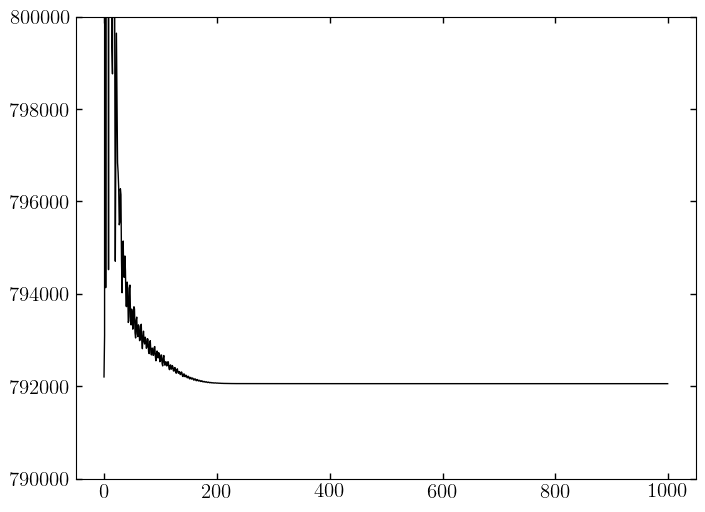

In [245]:
print(bkg_svi_results.losses[-1])
plt.plot(bkg_svi_results.losses, lw=1)
plt.ylim(7.9e5, 8e5)
# plt.yscale('log')

plt.show()

In [246]:
bkg_params = get_svi_params(model=bkg_model, data=bkg_data, svi_results=bkg_svi_results, 
                            guide=bkg_guide, num_samples=1, key=jax.random.PRNGKey(12345))

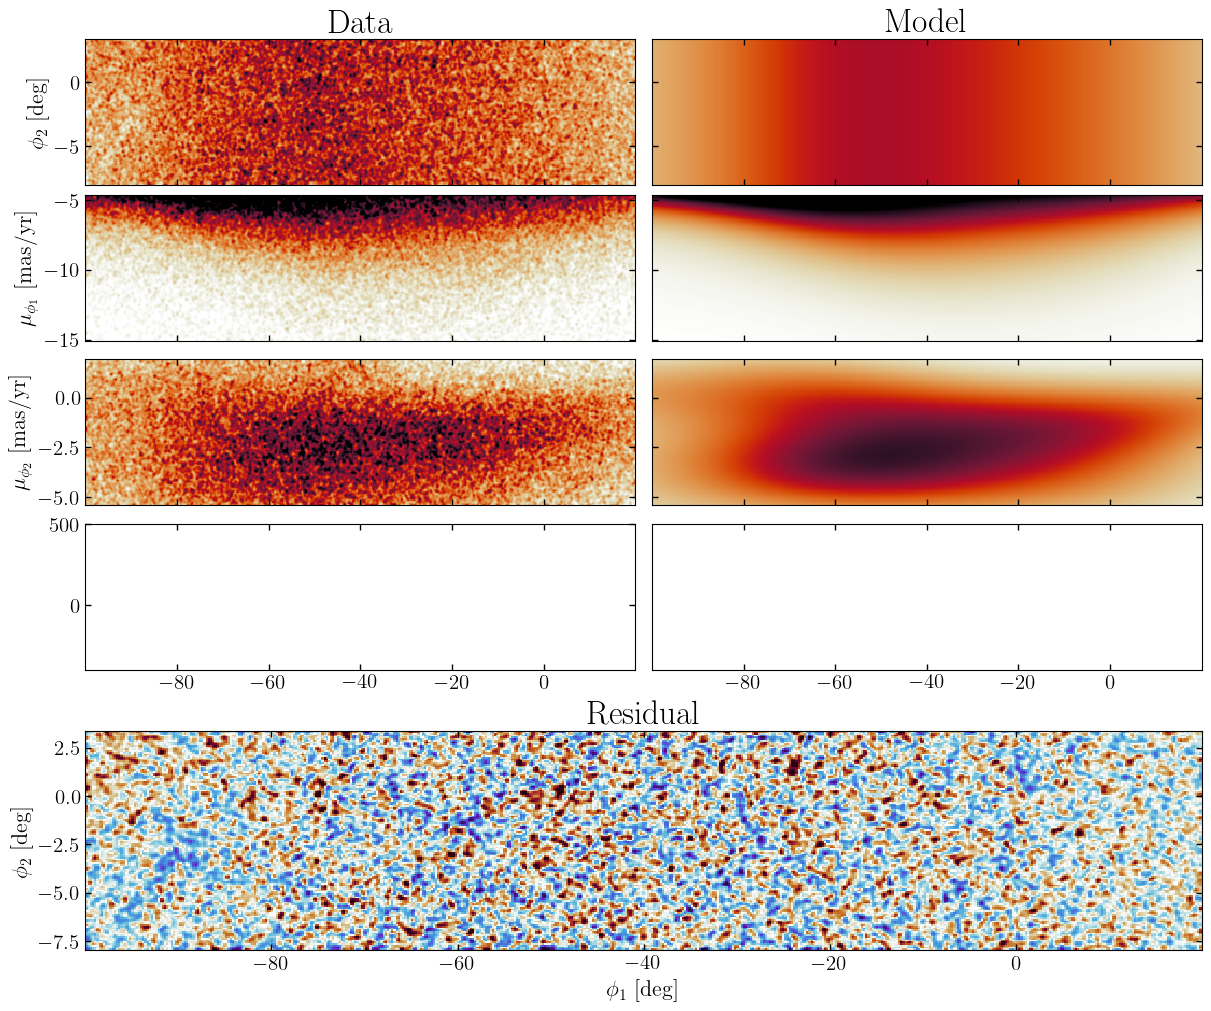

In [247]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)
ax7 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax8 = fig.add_subplot(gs[3, 1], sharex=ax1, sharey=ax7)

ax9 = fig.add_subplot(gs[4, :], sharex=ax1)

plot_data_projections(
    data=bkg_data,
    grids=plot_grids,
    axes=ax3,
    coord_names=[('phi1', 'pm1')],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=bkg_data,
    grids=plot_grids,
    axes=[ax1, ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)

bkg_model.plot_model_projections(ndata=len(bkg_data_), grids=plot_grids, 
                          grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm1')],
                          pars=bkg_params, axes=[ax2,ax4], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
bkg_model.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                          pars=bkg_params, axes=[ax2,ax6], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))

bkg_model.plot_residual_projections(
    grids=plot_grids, pars=bkg_params,
    data=bkg_data, axes=ax9, label=True, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion),
    grid_coord_names=[('phi1', 'phi2')]
)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.label_outer()
ax8.yaxis.set_visible(False)
ax8.set_ylim(-400,500)

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax9.set_title('Residual', fontsize=24, pad=5)

plt.show()

In [249]:
bkg_filename = svi_no_rv_results_dir + 'bkg_{}_{}_{}_auto_delta.pkl'.format(*bkg_knot_spacings)
bkg_dict = {'svi_results': bkg_svi_results,
            'guide': bkg_guide,
           }
with open(bkg_filename, 'wb') as param_file:
    pickle.dump(bkg_dict, param_file)

## Stream

In [357]:
stream_knot_spacings = jnp.array([5,10,10,10])

In [361]:
stream_filename = svi_no_rv_results_dir + 'stream_{}_{}_{}_{}_auto_delta.pkl'.format(*stream_knot_spacings)

with open(stream_filename, 'rb') as input_file_:
    full_dict = pickle.load(input_file_)
    
stream_svi_results = full_dict['svi_results']
stream_guide = full_dict['guide']

In [362]:
from scipy.stats import binned_statistic
phi1_knot_spacing, phi2_knot_spacing, pm1_knot_spacing, pm2_knot_spacing = stream_knot_spacings

stream_phi1_knots = jnp.arange(jnp.around(phi1_lim[0]), jnp.around(phi1_lim[1]) + 1e-3, phi1_knot_spacing)
stream_phi2_knots = jnp.arange(jnp.around(phi1_lim[0]), jnp.around(phi1_lim[1]) + 1e-3, phi2_knot_spacing)
stream_pm1_knots  = jnp.arange(jnp.around(phi1_lim[0]), jnp.around(phi1_lim[1]) + 1e-3, pm1_knot_spacing)
stream_pm2_knots  = jnp.arange(jnp.around(phi1_lim[0]), jnp.around(phi1_lim[1]) + 1e-3, pm2_knot_spacing)

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=jnp.linspace(phi1_lim[0], phi1_lim[1], 21))
_phi2_interp = IUS(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic, ext=0, k=3
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=jnp.linspace(phi1_lim[0], phi1_lim[1], 32))
_pm1_interp = IUS(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=0, k=3
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=jnp.linspace(phi1_lim[0], phi1_lim[1], 32))
_pm2_interp = IUS(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=0, k=3
)

_interp_dict = {'phi2': _phi2_interp, 'pm1': _pm1_interp, 'pm2': _pm2_interp}

eval_interp_phi2 = jnp.array(_interp_dict['phi2'](stream_phi2_knots))
eval_interp_pm1 = jnp.array(_interp_dict['pm1'](stream_pm1_knots))
eval_interp_pm2 = jnp.array(_interp_dict['pm2'](stream_pm2_knots))

stream_model = ModelComponent(
    name="stream",
    coord_distributions={
        "phi1": IndependentGMM,
        "phi2": TruncatedNormalSpline,
        "pm1": TruncatedNormalSpline,
        "pm2": TruncatedNormalSpline,
    },
    coord_parameters={
        "phi1": {
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(len(stream_phi1_knots))),
            ),
            "locs": stream_phi1_knots.reshape(1, -1),
            "scales": dist.TruncatedNormal(loc=0.5*phi1_knot_spacing, scale=0.5*phi1_knot_spacing,
                                           low=0.1*phi1_knot_spacing).expand([stream_phi1_knots.shape[0]]),
            "low": jnp.array([phi1_lim[0]])[:, None],
            "high": jnp.array([phi1_lim[1]])[:, None],
        },
        "phi2": {
            # "loc_vals": dist.Uniform(*phi2_lim).expand([stream_phi2_knots.shape[0]]),
            "loc_vals": dist.TruncatedNormal(loc=eval_interp_phi2, scale=1,low=phi2_lim[0],high=phi2_lim[1]).expand([stream_phi2_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=0.5,scale=0.5,low=0.05).expand([stream_phi2_knots.shape[0]]),
            "knots": stream_phi2_knots,
            "x": stream_data["phi1"],
            "low": phi2_lim[0],
            "high": phi2_lim[1],
            "spline_k": 3,
            "clip_scales": (0.05, None),
        },
        "pm1": {
            # "loc_vals": dist.Uniform(*pm1_lim).expand([stream_pm1_knots.shape[0]]),
            "loc_vals": dist.TruncatedNormal(loc=eval_interp_pm1, scale=2, low=pm1_lim[0],high=pm1_lim[1]).expand([stream_pm1_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=0.1,scale=0.5,low=2.78e-3, high=2).expand([stream_pm1_knots.shape[0]]),
            "knots": stream_pm1_knots,
            "x": stream_data["phi1"],
            "low": pm1_lim[0],
            "high": pm1_lim[1],
            "spline_k": 3,
            "clip_locs": pm1_lim,
            "clip_scales": (2.78e-3, 2),
        },
        "pm2": {
            # "loc_vals": dist.Uniform(*pm2_lim).expand([stream_pm2_knots.shape[0]]),
            "loc_vals": dist.TruncatedNormal(loc=eval_interp_pm2, scale=2, low=pm2_lim[0],high=pm2_lim[1]).expand([stream_pm2_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=0.1,scale=0.5,low=2.78e-3, high=2).expand([stream_pm2_knots.shape[0]]),
            "knots": stream_pm2_knots,
            "x": stream_data["phi1"],
            "low": pm2_lim[0],
            "high": pm2_lim[1],
            "spline_k": 3,
            "clip_locs": pm2_lim,
            "clip_scales": (2.78e-3, 2),
        },
    },
    conditional_data={"phi2": {"x": "phi1"}, 
                      "pm1": {"x": "phi1"}, 
                      "pm2": {"x": "phi1"},}
)

In [363]:
stream_init_params = {
    "phi1": {
        "mixing_distribution": jnp.ones(len(stream_phi1_knots))
        / len(stream_phi1_knots),
        "scales": jnp.full(stream_phi1_knots.shape[0], stream_knot_spacings[0]),
    },
    "phi2": {
        "loc_vals": eval_interp_phi2,
        "scale_vals": jnp.full(stream_phi2_knots.shape[0], 0.5),
    },
    "pm1": {
        "loc_vals": eval_interp_pm1,
        "scale_vals": jnp.full(stream_pm1_knots.shape[0], 0.35),
    },
    "pm2": {
        "loc_vals": eval_interp_pm2,
        "scale_vals": jnp.full(stream_pm2_knots.shape[0], 0.35),
    },
}

In [135]:
stream_frozen_params = {}#{'stream:pm1:modeldata_auto_loc', 'stream:pm2:modeldata_auto_loc', 'stream:rv:modeldata_auto_loc'}
# Parameter grouping
def param_labels(param_tree):
    """
    Assign labels to parameters based on whether they should be frozen or trainable.
    """
    labels = {}
    for key in param_tree.keys():
        labels[key] = "frozen" if key in stream_frozen_params else "trainable"
    return labels

In [136]:
keys=jax.random.split(jax.random.PRNGKey(42), num=2)
init_lr = 1e-2
num_steps = 7_500

# Define step intervals
eighth_steps = num_steps // 8
quarter_steps = num_steps // 4
half_steps = num_steps // 2

lr_schedule = optax.join_schedules(
        schedules=[
            optax.constant_schedule(init_lr),
            optax.constant_schedule(init_lr/10),
            optax.constant_schedule(init_lr/100)
            # optax.cosine_decay_schedule(init_value=init_lr/10, decay_steps=5_000, alpha=8e-1),
            # optax.cosine_decay_schedule(init_value=init_lr/10, decay_steps=10_000, alpha=1e-1),
        ],
        boundaries=[2500, 
                    2700
                   ]
    )


# Define optimizers for frozen and trainable parameters
frozen_optimizer = optax.set_to_zero()  # No updates for frozen parameters
# trainable_optimizer = optax.chain(optax.clip(10.),
#                                 optax.adam(learning_rate=lr_schedule)
#                                 )
trainable_optimizer = optax.chain(optax.clip(10),
                                optax.adam(learning_rate=1e-2)
                                )

stream_masked_optimizer = optax.multi_transform(
    {
        "frozen": frozen_optimizer,
        "trainable": trainable_optimizer,
    },
    param_labels
)

# Convert to NumPyro optimizer
stream_optimizer = numpyro.optim.optax_to_numpyro(stream_masked_optimizer)

stream_guide = AutoDelta(
        stream_model, init_loc_fn=numpyro.infer.init_to_value(values=stream_init_params)
    )
svi = SVI(stream_model, stream_guide, stream_optimizer, Trace_ELBO(num_particles=3))
with numpyro.validation_enabled(), jax.debug_nans():
    # Initialize and run the SVI optimization
    stream_init_state = svi.init(keys[0], init_params=stream_init_params, data=stream_data, err=stream_data_err)
    print(svi.evaluate(stream_init_state, data=stream_data, err=stream_data_err))

1221912.6859745318


In [137]:
stream_svi_results = svi.run(
            rng_key=keys[1], num_steps=10_000, init_state=stream_init_state, 
            data=stream_data, err=stream_data_err
        )

100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 228.33it/s, init loss: 1221912.6860, avg. loss [9501-10000]: 2281.5051]


In [139]:
stream_svi_results = svi.run(
            rng_key=keys[1], num_steps=25_000, init_state=stream_svi_results.state, 
            data=stream_data, err=stream_data_err
        )

100%|█████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [01:58<00:00, 211.05it/s, init loss: 2314.3795, avg. loss [23751-25000]: 2295.6417]


2275.0641682382584


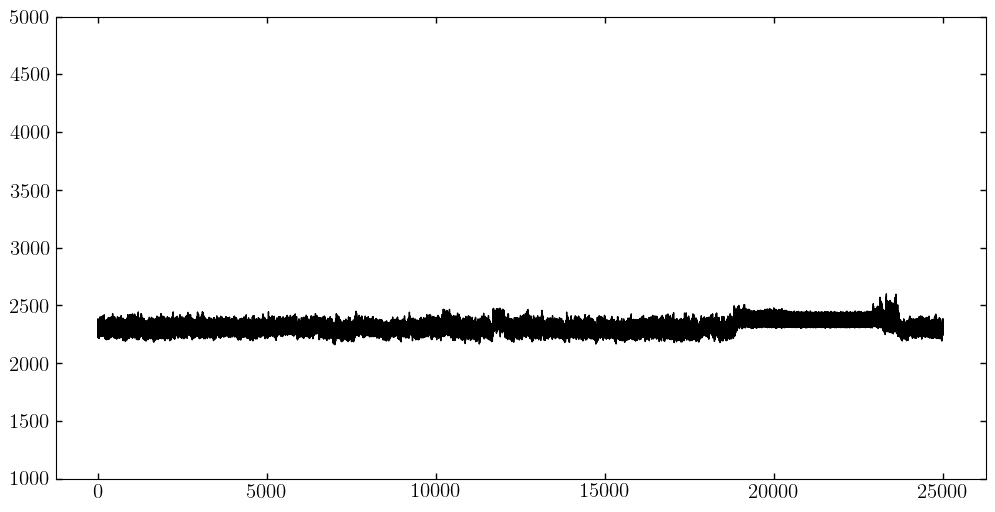

In [140]:
plt.figure(figsize=(12,6))
plt.plot(stream_svi_results.losses, lw=1)
print(stream_svi_results.losses[-1])
plt.ylim(1e3,5e3)
# plt.yscale('log')
plt.show()

In [141]:
stream_params = get_svi_params(model=stream_model, data=stream_data, svi_results=stream_svi_results, 
                               guide=stream_guide, num_samples=1, key=jax.random.PRNGKey(12345))

In [142]:
pred_dist = Predictive(stream_guide, params=stream_svi_results.params, num_samples=1)
pars_ = pred_dist(jax.random.PRNGKey(42), data=stream_data)

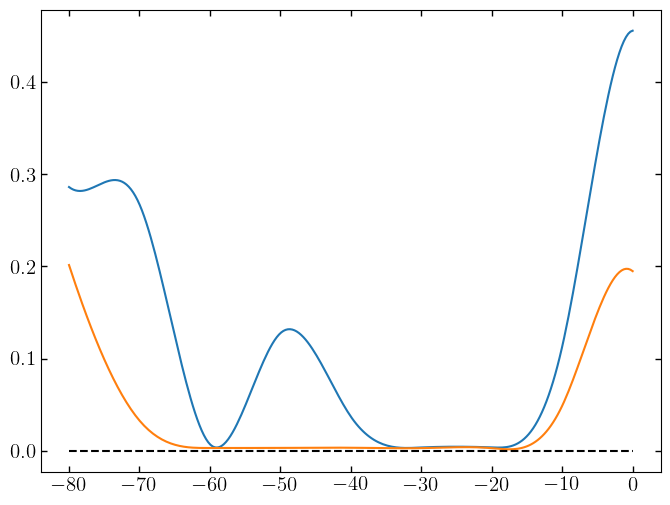

In [143]:
xgrid = np.linspace(-80, 0, 256)

for name, color in zip(["pm1", "pm2"], ["tab:blue", "tab:orange"]):
    spl_grid = np.zeros((pars_[f'stream:{name}:scale_vals'].shape[0], len(xgrid)))
    for i in range(pars_[f'stream:{name}:scale_vals'].shape[0]):
        spl = IUS(stream_model.coord_parameters[name]['knots'], pars_[f'stream:{name}:scale_vals'][i], k=3)
        spl_grid[i] = spl(xgrid)
    plt.plot(xgrid, spl_grid.T, alpha=1, color=color);
plt.hlines(0, xmin=-80, xmax=0, ls='--')
# plt.ylim(-0.05,0.1)

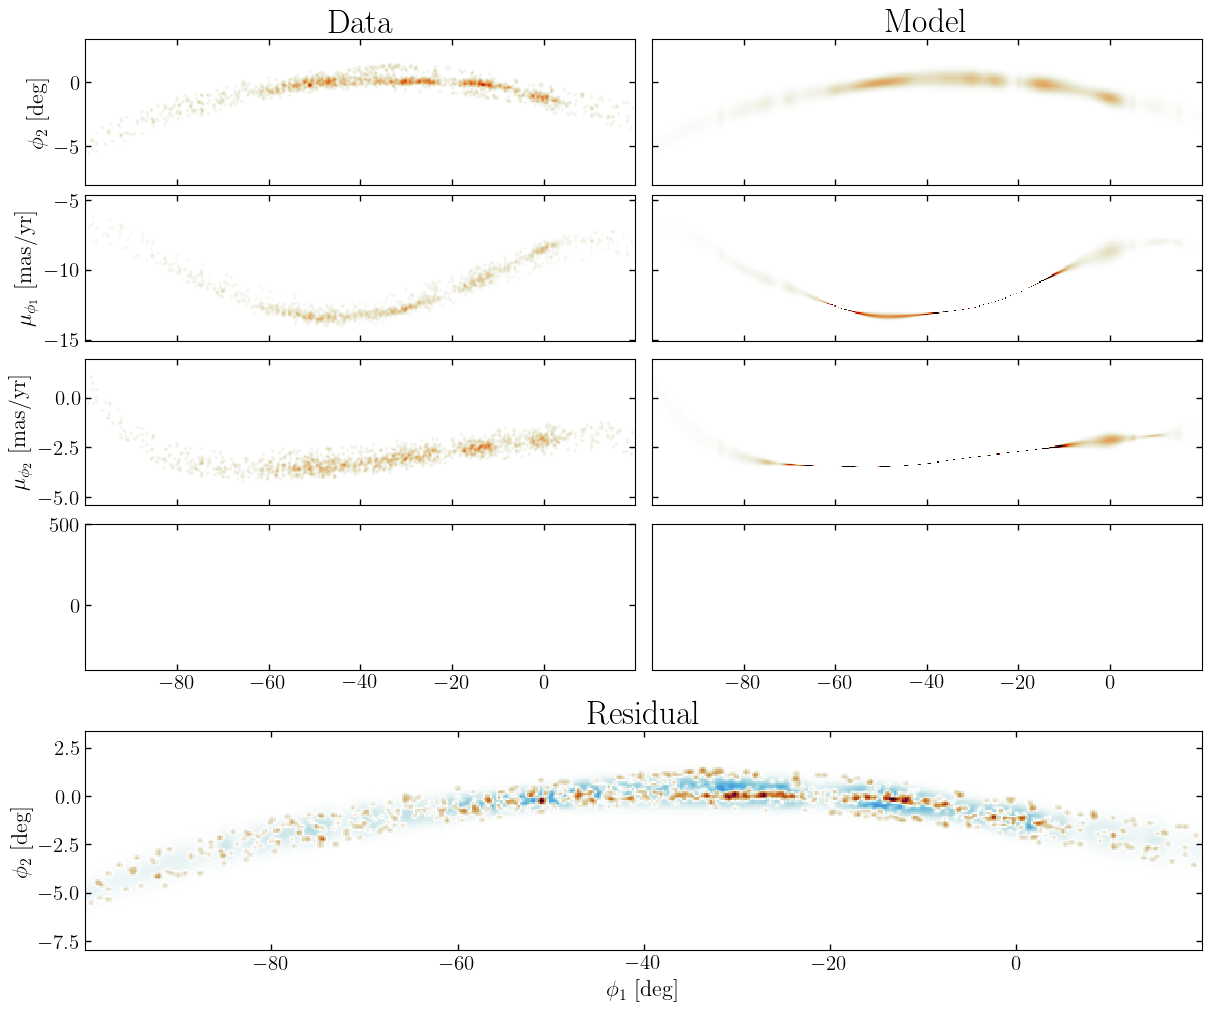

In [144]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)
ax7 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax8 = fig.add_subplot(gs[3, 1], sharex=ax1, sharey=ax7)

ax9 = fig.add_subplot(gs[4, :], sharex=ax1)

plot_data_projections(
    data=stream_data,
    grids=plot_grids,
    axes=ax3,
    coord_names=[('phi1', 'pm1')],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=stream_data,
    grids=plot_grids,
    axes=[ax1, ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)
stream_model.plot_model_projections(ndata=len(stream_data_), grids=plot_grids, 
                          grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm1')],
                          pars=stream_params, axes=[ax2,ax4], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
stream_model.plot_model_projections(ndata=len(stream_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                          pars=stream_params, axes=[ax2,ax6], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))

stream_model.plot_residual_projections(
    grids=plot_grids, pars=stream_params,
    data=stream_data, axes=ax9, label=True, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion),
    grid_coord_names=[('phi1', 'phi2')]
)


for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.label_outer()
ax8.yaxis.set_visible(False)
ax8.set_ylim(-400,500)

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax9.set_title('Residual', fontsize=24, pad=5)

# plt.savefig('../../paper_figures/bkg_model.pdf')
plt.show()

In [145]:
stream_filename = svi_no_rv_results_dir + 'stream_{}_{}_{}_{}_auto_delta.pkl'.format(*stream_knot_spacings)
stream_dict = {'svi_results': stream_svi_results,
            'guide': stream_guide,
               'params': stream_params
           }
with open(stream_filename, 'wb') as param_file:
    pickle.dump(stream_dict, param_file)

# Stream+Background

In [364]:
bkg_mm_filename = svi_no_rv_results_dir + 'bkg_{}_{}_{}_auto_delta.pkl'.format(*bkg_knot_spacings)

with open(bkg_mm_filename, 'rb') as input_file_:
    full_dict = pickle.load(input_file_)
    
bkg_svi_results = full_dict['svi_results']
bkg_guide = full_dict['guide']

stream_mm_filename = svi_no_rv_results_dir + 'stream_{}_{}_{}_{}_auto_delta.pkl'.format(*stream_knot_spacings)

with open(stream_mm_filename, 'rb') as input_file_:
    full_dict = pickle.load(input_file_)
    
stream_svi_results = full_dict['svi_results']
stream_guide = full_dict['guide']

In [365]:
bkg_model_mm = ModelComponent(
    name="background",
    coord_distributions={
        "phi1": IndependentGMM,
        "phi2": dist.Uniform,
        "pm1": TruncatedNormal1DSplineMixture,
        "pm2": TruncatedNormal1DSplineMixture
    },
    coord_parameters={
        "phi1": {
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(len(bkg_phi1_knots))),
            ),
            "locs": bkg_phi1_knots.reshape(1, -1),
            "scales": dist.TruncatedNormal(loc=0.5*phi1_knot_spacing, scale=0.5*phi1_knot_spacing,
                                           low=0.1*phi1_knot_spacing).expand([bkg_phi1_knots.shape[0]]),
            "low":  jnp.array([phi1_lim[0]])[:, None],
            "high": jnp.array([phi1_lim[1]])[:, None],                  
        },
        "phi2": {
            "low": phi2_lim[0],
            "high": phi2_lim[1],
        },
        "pm1": {
            # "mixing_vals": dist.Dirichlet(jnp.ones((n_mixture, bkg_pm1_knots.shape[0]))),
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(n_mixture)) # two truncated normals
            ),
            "loc_vals": dist.Uniform(low=-10, high=10).expand([n_mixture, bkg_pm1_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=4,scale=3,low=2.78e-3).expand([n_mixture, bkg_pm1_knots.shape[0]]),
            "knots": bkg_pm1_knots,
            "x": run_data["phi1"],
            "low": pm1_lim[0],
            "high": pm1_lim[1],
            "spline_k": 3,
            "clip_locs": (-10,10),
            "clip_scales": (2.78e-3, None),
        },
        "pm2": {
            # "mixing_vals": dist.Dirichlet(jnp.ones((n_mixture, bkg_pm2_knots.shape[0]))),
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(n_mixture)) # two truncated normals
            ),
            "loc_vals": dist.Uniform(low=-10, high=10).expand([n_mixture, bkg_pm2_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=4,scale=3,low=2.78e-3).expand([n_mixture, bkg_pm2_knots.shape[0]]),
            "knots": bkg_pm2_knots,
            "x": run_data["phi1"],
            "low": pm2_lim[0],
            "high": pm2_lim[1],
            "spline_k": 3,
            "clip_locs": (-10, 10),
            "clip_scales": (2.78e-3, None),
        },
    },
    conditional_data={"pm1": {"x": "phi1"}, 
                      "pm2": {"x": "phi1"},
                     }
)


stream_model_mm = ModelComponent(
    name="stream",
    coord_distributions={
        "phi1": IndependentGMM,
        "phi2": TruncatedNormalSpline,
        "pm1": TruncatedNormalSpline,
        "pm2": TruncatedNormalSpline,
    },
    coord_parameters={
        "phi1": {
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(len(stream_phi1_knots))),
            ),
            "locs": stream_phi1_knots.reshape(1, -1),
            "scales": dist.TruncatedNormal(loc=0.5*phi1_knot_spacing, scale=0.5*phi1_knot_spacing,
                                           low=0.1*phi1_knot_spacing).expand([stream_phi1_knots.shape[0]]),
            "low": jnp.array([phi1_lim[0]])[:, None],
            "high": jnp.array([phi1_lim[1]])[:, None],
        },
        "phi2": {
            # "loc_vals": dist.Uniform(*phi2_lim).expand([stream_phi2_knots.shape[0]]),
            "loc_vals": dist.TruncatedNormal(loc=eval_interp_phi2, scale=1,low=phi2_lim[0],high=phi2_lim[1]).expand([stream_phi2_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=0.5,scale=0.5,low=0.05).expand([stream_phi2_knots.shape[0]]),
            "knots": stream_phi2_knots,
            "x": run_data["phi1"],
            "low": phi2_lim[0],
            "high": phi2_lim[1],
            "spline_k": 3,
            "clip_scales": (0.05, None),
        },
        "pm1": {
            # "loc_vals": dist.Uniform(*pm1_lim).expand([stream_pm1_knots.shape[0]]),
            "loc_vals": dist.TruncatedNormal(loc=eval_interp_pm1, scale=2, low=pm1_lim[0],high=pm1_lim[1]).expand([stream_pm1_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=0.1,scale=0.5,low=2.78e-3, high=2).expand([stream_pm1_knots.shape[0]]),
            "knots": stream_pm1_knots,
            "x": run_data["phi1"],
            "low": pm1_lim[0],
            "high": pm1_lim[1],
            "spline_k": 3,
            "clip_locs": pm1_lim,
            "clip_scales": (2.78e-3, 2),
        },
        "pm2": {
            # "loc_vals": dist.Uniform(*pm2_lim).expand([stream_pm2_knots.shape[0]]),
            "loc_vals": dist.TruncatedNormal(loc=eval_interp_pm2, scale=2, low=pm2_lim[0],high=pm2_lim[1]).expand([stream_pm2_knots.shape[0]]),
            "scale_vals": dist.TruncatedNormal(loc=0.1,scale=0.5,low=2.78e-3, high=2).expand([stream_pm2_knots.shape[0]]),
            "knots": stream_pm2_knots,
            "x": run_data["phi1"],
            "low": pm2_lim[0],
            "high": pm2_lim[1],
            "spline_k": 3,
            "clip_locs": pm2_lim,
            "clip_scales": (2.78e-3, 2),
        },
    },
    conditional_data={"phi2": {"x": "phi1"}, 
                      "pm1": {"x": "phi1"}, 
                      "pm2": {"x": "phi1"},}
)

In [366]:
stream_bkg_mm = ComponentMixtureModel(dist.Dirichlet(jnp.array([1.0, 1.0])), 
                                          components=[bkg_model_mm, stream_model_mm])

In [367]:
bkg_indices = np.where(np.isin(run_data['phi1'], bkg_data['phi1']))[0]
stream_indices = np.where(np.isin(run_data['phi1'], stream_data['phi1']))[0]
modeldata = np.zeros((len(run_data['phi1']), 4))
modeldata[:,0] = run_data['phi1']
modeldata[:,1] = run_data['phi2']
modeldata[stream_indices,2] = run_data_['pm1'][stream_indices]
modeldata[stream_indices,3] = run_data_['pm2'][stream_indices]
modeldata[bkg_indices,2] = run_data_['pm1'][bkg_indices]
modeldata[bkg_indices,3] = run_data_['pm2'][bkg_indices]

In [368]:
init_params = bkg_svi_results.params | stream_svi_results.params
init_params["mixture-probs"] = jnp.array([0.98, 0.02])
init_params['mixture:modeldata_auto_loc'] = modeldata

In [369]:
del init_params['background:pm1:modeldata_auto_loc']
del init_params['background:pm2:modeldata_auto_loc']
del init_params['stream:pm1:modeldata_auto_loc']
del init_params['stream:pm2:modeldata_auto_loc']

In [370]:
init_params

{'background:phi1:mixing_distribution_auto_loc': Array([0.17640842, 0.30076288, 0.49992193, 0.02290677], dtype=float64),
 'background:phi1:scales_auto_loc': Array([46.66409383, 21.40235002, 30.51411343, 24.83804482], dtype=float64),
 'background:pm1:loc_vals_auto_loc': Array([[ 9.91497241,  0.28335366,  2.25872605,  9.34237924],
        [ 9.23501897, -0.92857402, -2.13186818,  8.80414953]],      dtype=float64),
 'background:pm1:mixing_distribution_auto_loc': Array([0.55759999, 0.44240001], dtype=float64),
 'background:pm1:scale_vals_auto_loc': Array([[3.85490589, 3.34318958, 4.35539455, 4.34514054],
        [6.36770992, 4.22742432, 3.87754715, 7.17817066]], dtype=float64),
 'background:pm2:loc_vals_auto_loc': Array([[ 0.38080688, -0.34182943, -1.09405488, -0.5843346 ],
        [-3.45543696, -3.40604601, -3.24039043, -2.7090773 ]],      dtype=float64),
 'background:pm2:mixing_distribution_auto_loc': Array([0.39614061, 0.60385939], dtype=float64),
 'background:pm2:scale_vals_auto_loc': A

In [371]:
stream_bkg_frozen_params = {}
# Parameter grouping
def stream_bkg_param_labels(param_tree):
    """
    Assign labels to parameters based on whether they should be frozen or trainable.
    """
    labels = {}
    for key in param_tree.keys():
        labels[key] = "frozen" if key in stream_bkg_frozen_params else "trainable"
    return labels

In [385]:
keys=jax.random.split(jax.random.PRNGKey(42), num=2)
init_lr = 1e-3
num_steps=10_000

# stream_bkg_optimizer = numpyro.optim.ClippedAdam(1e-2)

# Define the base optimizer
# base_optimizer = optax.adam(learning_rate=init_lr)

# Define step intervals
fiftieth_steps = num_steps // 50
tenth_steps = num_steps // 10
quarter_steps = num_steps // 4
half_steps = num_steps // 2

lr_schedule = optax.join_schedules(
        schedules=[
            # optax.constant_schedule(init_lr),
            optax.cosine_decay_schedule(init_value=init_lr, decay_steps=500, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/10, decay_steps=2_000, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/100, decay_steps=4_000, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/1000, decay_steps=3_000, alpha=1e-1),
        ],
        boundaries=[500, 
                    2_500,
                    6_500
                   ]
    )


# Define optimizers for frozen and trainable parameters
frozen_optimizer = optax.set_to_zero()  # No updates for frozen parameters
trainable_optimizer = optax.chain(optax.clip(10.),
                                optax.adam(learning_rate=lr_schedule)
                                )
# trainable_optimizer = optax.chain(optax.clip(10.),
#                                 optax.adam(learning_rate=1e-1)
#                                 )


# # Combine with `optax.masked`
# masked_optimizer = optax.chain(optax.clip(10.),
#                                optax.masked(optax.adam(learning_rate=lr_schedule), mask_fn),  # Mask updates for frozen parameters
#                                optax.set_to_zero()  # Explicitly zero out gradients for masked parameters
# )
# Combine optimizers using multi_transform
masked_optimizer = optax.multi_transform(
    {
        "frozen": frozen_optimizer,
        "trainable": trainable_optimizer,
    },
    stream_bkg_param_labels
)

# Convert to NumPyro optimizer
stream_bkg_optimizer = numpyro.optim.optax_to_numpyro(masked_optimizer)

stream_bkg_guide = AutoDelta(
        stream_bkg_mm, init_loc_fn=numpyro.infer.init_to_value(values=init_params)
    )
stream_bkg_svi = SVI(stream_bkg_mm, stream_bkg_guide, stream_bkg_optimizer, Trace_ELBO(num_particles=3))
with numpyro.validation_enabled(), jax.debug_nans():
    # Initialize and run the SVI optimization
    stream_bkg_init_state = stream_bkg_svi.init(keys[0], init_params=init_params, data=run_data, err=run_data_err)
    print(stream_bkg_svi.evaluate(stream_bkg_init_state, data=run_data, err=run_data_err))

-576362.6136287856


In [386]:
stream_bkg_svi_results = stream_bkg_svi.run(
            rng_key=keys[1], num_steps=100, init_state=stream_bkg_init_state, 
            data=run_data, err=run_data_err
        )

100%|████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s, init loss: -576362.6136, avg. loss [96-100]: 58508261.1584]


In [392]:
stream_bkg_svi_results = stream_bkg_svi.run(
            rng_key=keys[1], num_steps=900, init_state=stream_bkg_svi_results.state, 
            data=run_data, err=run_data_err
        )

100%|███████████████████████████████████████████████████████████████████████████████████████████| 900/900 [11:43<00:00,  1.28it/s, init loss: 84921330.6902, avg. loss [856-900]: -310529.6652]


In [172]:
stream_bkg_svi_results = stream_bkg_svi.run(
            rng_key=keys[1], num_steps=7_000, init_state=stream_bkg_svi_results.state, 
            data=run_data, err=run_data_err
        )

100%|█████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [1:31:58<00:00,  1.27it/s, init loss: 42584269.8148, avg. loss [6651-7000]: -585060.1692]


-331859.4050562711


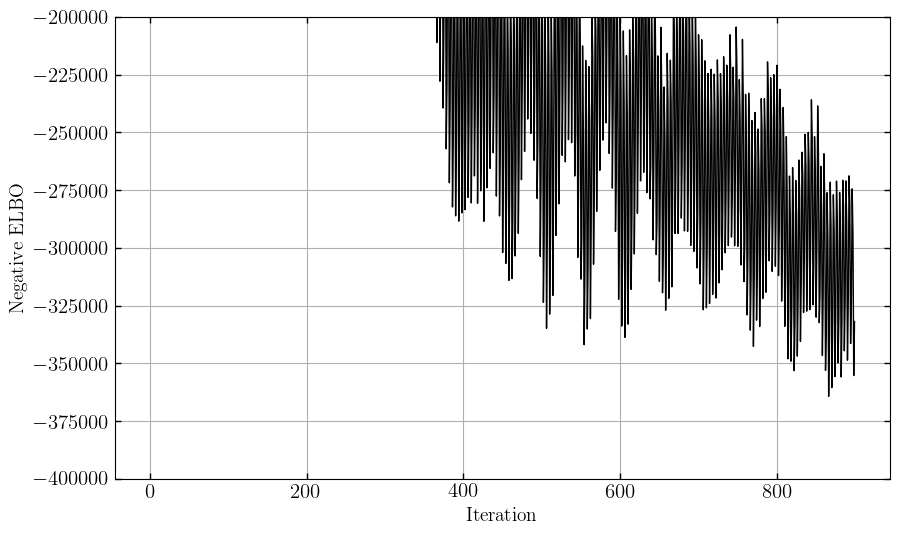

In [394]:
print(stream_bkg_svi_results.losses[-1])
plt.figure(figsize=(10,6))
plt.plot(stream_bkg_svi_results.losses, lw=1)
plt.ylim(-4e5, -2e5)
# plt.yscale('log')
plt.xlabel('Iteration') ; plt.ylabel('Negative ELBO')
plt.grid()
plt.show()

In [381]:
pred_dist = Predictive(stream_bkg_guide, params=init_params, num_samples=1)
pars_ = pred_dist(rng_key=jax.random.PRNGKey(42), data=run_data)
pars = {k: jnp.median(v, axis=0) for k, v in pars_.items() if (k != '_auto_latent' and k != 'mixture:modeldata')}
stream_bkg_params = stream_bkg_mm.expand_numpyro_params(pars)

In [395]:
stream_bkg_params = get_svi_params(stream_bkg_mm, run_data, stream_bkg_svi_results, stream_bkg_guide, 
                                num_samples=1, key=jax.random.PRNGKey(42))

In [396]:
print(stream_bkg_params['mixture-probs'])

[0.98544321 0.01455679]


(-100.0, 20.0)

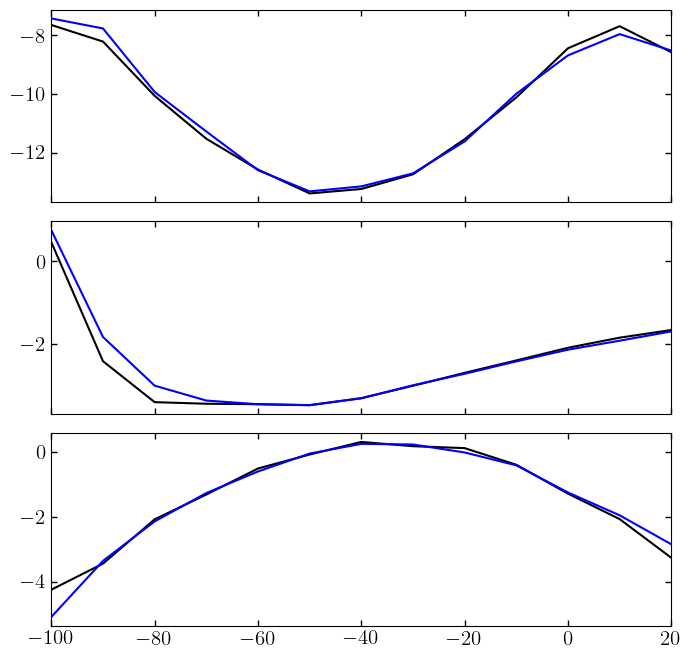

In [397]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(8,8), sharex=True)
ax1.plot(stream_model_mm.coord_parameters['pm1']['knots'], stream_bkg_params['stream']['pm1']['loc_vals'])
ax1.plot(stream_model.coord_parameters['pm1']['knots'], stream_params['pm1']['loc_vals'])

ax2.plot(stream_model_mm.coord_parameters['pm2']['knots'], stream_bkg_params['stream']['pm2']['loc_vals'])
ax2.plot(stream_model.coord_parameters['pm2']['knots'], stream_params['pm2']['loc_vals'])

ax3.plot(stream_model_mm.coord_parameters['phi2']['knots'], stream_bkg_params['stream']['phi2']['loc_vals'])
ax3.plot(stream_model.coord_parameters['phi2']['knots'], stream_params['phi2']['loc_vals'])
ax3.set_xlim(-100,20)

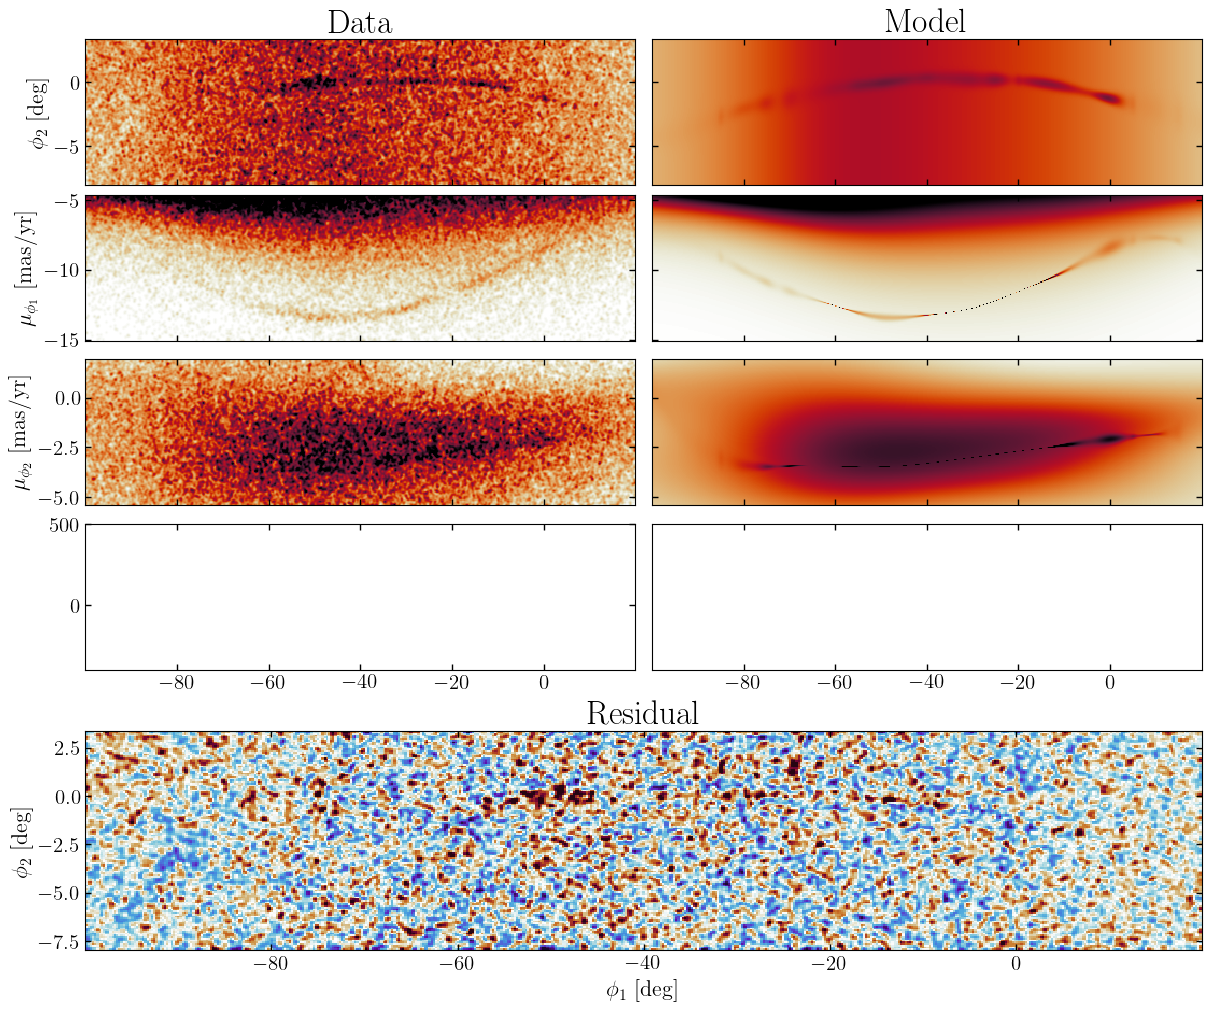

In [398]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)
ax7 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax8 = fig.add_subplot(gs[3, 1], sharex=ax1, sharey=ax7)

ax9 = fig.add_subplot(gs[4, :], sharex=ax1)

plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=ax3,
    coord_names=[('phi1', 'pm1')],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=[ax1, ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)

stream_bkg_mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, 
                          grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm1')],
                          pars=stream_bkg_params, axes=[ax2,ax4], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
stream_bkg_mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                          pars=stream_bkg_params, axes=[ax2,ax6], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))

stream_bkg_mm.plot_residual_projections(
    grids=plot_grids, pars=stream_bkg_params,
    data=run_data, axes=ax9, label=True, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion),
    grid_coord_names=[('phi1', 'phi2')]
)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.label_outer()
ax8.yaxis.set_visible(False)
ax8.set_ylim(-400,500)

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax9.set_title('Residual', fontsize=24, pad=5)

plt.show()

In [400]:
specs = jnp.concatenate([bkg_knot_spacings, stream_knot_spacings])
stream_bkg_mm_filename = svi_no_rv_results_dir + 'mm_bkg{}_{}_{}_stream{}_{}_{}_{}_auto_delta.pkl'.format(*specs)
stream_bkg_dict = {'svi_results': stream_bkg_svi_results,
            'guide': stream_bkg_guide,
            'params': stream_bkg_params
           }
with open(stream_bkg_mm_filename, 'wb') as param_file:
    pickle.dump(stream_bkg_dict, param_file)

## Full Model

In [401]:
# make offtrack model
offtrack_phi1_dx, offtrack_phi2_dx = offtrack_dx

phi1_lim = coord_bounds['phi1']
phi2_lim = coord_bounds['phi2']

offtrack_phi12_locs = jnp.stack(
jnp.meshgrid(
    jnp.arange(phi1_lim[0]+offtrack_phi1_dx, 
               phi1_lim[1]-offtrack_phi1_dx/2 + 1e-3, #factor of two added by hand to make sure the high phi1 edge is properly included
               offtrack_phi1_dx),
    jnp.arange(phi2_lim[0]+offtrack_phi2_dx, 
               phi2_lim[1]-offtrack_phi2_dx/2 + 1e-3, 
               offtrack_phi2_dx),
),
axis=-1,
).reshape(-1, 2)

In [402]:
offtrack_model = ModelComponent(
        name="offtrack",
        coord_distributions={
            ("phi1", "phi2"): IndependentGMM,
            "pm1": stream_model.coord_distributions["pm1"],
            "pm2": stream_model.coord_distributions["pm2"],
        },
        coord_parameters={
            ("phi1", "phi2"): {
                "mixing_distribution": (
                    dist.Categorical,
                    dist.Dirichlet(jnp.full(offtrack_phi12_locs.shape[0], 1)),
                ),
                "locs": offtrack_phi12_locs.T,
                "scales":
                    # dist.HalfNormal(jnp.array([offtrack_phi1_dx, offtrack_phi2_dx])[:, None]).expand(offtrack_phi12_locs.T.shape), 
                    dist.TruncatedNormal(loc=jnp.array(offtrack_dx)[:, None], scale=jnp.array(offtrack_dx)[:, None], 
                                         low=0.1*jnp.array(offtrack_dx)[:, None]).expand(offtrack_phi12_locs.T.shape),
                "low": jnp.array([phi1_lim[0], phi2_lim[0]])[:, None],
                "high": jnp.array([phi1_lim[1], phi2_lim[1]])[:, None],
            },
            # We don't need to define the parameters here, as they are the same as for the
            # stream model - this will be handled below when we combine the components into
            # a mixture model
            "pm1": stream_model.coord_parameters["pm1"],
            "pm2": stream_model.coord_parameters["pm2"],
        },
        conditional_data={"pm1": {"x": "phi1"}, "pm2": {"x": "phi1"}},
    )

In [405]:
offtrack_model.coord_parameters['pm1']['loc_vals'] = dist.TruncatedNormal(
    loc=stream_bkg_params['stream']['pm1']['loc_vals'],
    scale=stream_bkg_params['stream']['pm1']['scale_vals'],
    low=stream_bkg_params['stream']['pm1']['loc_vals']-3*stream_bkg_params['stream']['pm1']['scale_vals'],
    high=stream_bkg_params['stream']['pm1']['loc_vals']+3*stream_bkg_params['stream']['pm1']['scale_vals']
    )
offtrack_model.coord_parameters['pm2']['loc_vals'] = dist.TruncatedNormal(
    loc=stream_bkg_params['stream']['pm2']['loc_vals'],
    scale=stream_bkg_params['stream']['pm2']['scale_vals'],
    low=stream_bkg_params['stream']['pm2']['loc_vals']-3*stream_bkg_params['stream']['pm2']['scale_vals'],
    high=stream_bkg_params['stream']['pm2']['loc_vals']+3*stream_bkg_params['stream']['pm2']['scale_vals'])

offtrack_model.coord_parameters['pm1']['scale_vals'] = dist.TruncatedNormal(
    loc=stream_bkg_params['stream']['pm1']['scale_vals'],
    scale=stream_bkg_params['stream']['pm1']['scale_vals'] / 3,
    low=0, high=2*stream_bkg_params['stream']['pm1']['scale_vals'])
offtrack_model.coord_parameters['pm2']['scale_vals'] = dist.TruncatedNormal(
    loc=stream_bkg_params['stream']['pm2']['scale_vals'],
    scale=stream_bkg_params['stream']['pm2']['scale_vals'] / 3,
    low=0, high=2*stream_bkg_params['stream']['pm2']['scale_vals'])
offtrack_model.coord_parameters['pm1']['x'] = run_data['phi1']
offtrack_model.coord_parameters['pm2']['x'] = run_data['phi1']


mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0, 1.0])), #close to real solution
    components=[bkg_model_mm, stream_model_mm, offtrack_model],
)

In [439]:
init_params = stream_bkg_svi_results.params
# del init_params['mixture-probs_auto_loc']
foff = 0.001
fstream=0.015
fbkg = 1-fstream-foff


init_params['mixture-probs_auto_loc'] = jnp.array([fbkg,fstream,foff])

# init_params['mixture:modeldata_auto_loc'] = no_off_svi_results.params['mixture:modeldata_auto_loc']
# init_params['mixture:modeldata_auto_scale'] = no_off_svi_results.params['mixture:modeldata_auto_scale']

In [440]:
frozen_params = {'mixture:modeldata_auto_loc',
                 # 'mixture-probs_auto_loc',
                 # 'background:phi1:mixing_distribution_auto_loc', 'background:phi1:mixing_distribution_auto_scale', 
                 # 'background:phi1:scales_auto_loc', 'background:phi1:scales_auto_scale', 
                 # 'background:pm1:loc_vals_auto_loc', 'background:pm1:loc_vals_auto_scale', 
                 # 'background:pm1:mixing_distribution_auto_loc', 'background:pm1:mixing_distribution_auto_scale', 
                 # 'background:pm1:scale_vals_auto_loc', 'background:pm1:scale_vals_auto_scale', 
                 # 'background:pm2:loc_vals_auto_loc', 'background:pm2:loc_vals_auto_scale', 
                 # 'background:pm2:mixing_distribution_auto_loc', 'background:pm2:mixing_distribution_auto_scale', 
                 # 'background:pm2:scale_vals_auto_loc', 'background:pm2:scale_vals_auto_scale', 
                 # 'background:rv:loc_vals_auto_loc', 'background:rv:loc_vals_auto_scale', 
                 # 'background:rv:mixing_distribution_auto_loc', 'background:rv:mixing_distribution_auto_scale', 
                 # 'background:rv:scale_vals_auto_loc', 'background:rv:scale_vals_auto_scale',
                 # 'stream:phi1:mixing_distribution_auto_loc', 'stream:phi1:mixing_distribution_auto_scale', 
                 # 'stream:phi1:scales_auto_loc', 'stream:phi1:scales_auto_scale', 
                 # 'stream:phi2:loc_vals_auto_loc', 'stream:phi2:loc_vals_auto_scale', 
                 # 'stream:phi2:scale_vals_auto_loc', 'stream:phi2:scale_vals_auto_scale', 
                 # 'stream:pm1:loc_vals_auto_loc', 'stream:pm1:loc_vals_auto_scale', 
                 # 'stream:pm1:scale_vals_auto_loc', 'stream:pm1:scale_vals_auto_scale', 
                 # 'stream:pm2:loc_vals_auto_loc', 'stream:pm2:loc_vals_auto_scale', 
                 # 'stream:pm2:scale_vals_auto_loc', 'stream:pm2:scale_vals_auto_scale', 
                 # 'stream:rv:loc_vals_auto_loc', 'stream:rv:loc_vals_auto_scale', 
                 # 'stream:rv:scale_vals_auto_loc', 'stream:rv:scale_vals_auto_scale',
                 # 'offtrack:pm1:loc_vals_auto_loc', 'offtrack:pm1:loc_vals_auto_scale', 
                 # 'offtrack:pm1:scale_vals_auto_loc', 'offtrack:pm1:scale_vals_auto_scale', 
                 # 'offtrack:pm2:loc_vals_auto_loc', 'offtrack:pm2:loc_vals_auto_scale', 
                 # 'offtrack:pm2:scale_vals_auto_loc', 'offtrack:pm2:scale_vals_auto_scale', 
                 # 'offtrack:rv:loc_vals_auto_loc', 'offtrack:rv:loc_vals_auto_scale', 
                 # 'offtrack:rv:scale_vals_auto_loc', 'offtrack:rv:scale_vals_auto_scale',
                }

In [441]:
# Parameter grouping
def full_param_labels(param_tree):
    """
    Assign labels to parameters based on whether they should be frozen or trainable.
    """
    labels = {}
    for key in param_tree.keys():
        labels[key] = "frozen" if key in frozen_params else "trainable"
    return labels

In [443]:
keys=jax.random.split(jax.random.PRNGKey(42), num=2)
init_lr = 1e-1
num_steps = 10_000

# stream_bkg_optimizer = numpyro.optim.ClippedAdam(1e-2)

# Define the base optimizer
# base_optimizer = optax.adam(learning_rate=init_lr)

# Define step intervals
eighth_steps = num_steps // 8
quarter_steps = num_steps // 4
half_steps = num_steps // 2

lr_schedule = optax.join_schedules(
        schedules=[
            # optax.constant_schedule(init_lr),
            optax.cosine_decay_schedule(init_value=init_lr, decay_steps=quarter_steps, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/10, decay_steps=quarter_steps, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/100, decay_steps=quarter_steps, alpha=1e-1),
            optax.cosine_decay_schedule(init_value=init_lr/1000, decay_steps=quarter_steps, alpha=1e-1),
        ],
        boundaries=[quarter_steps,
                    half_steps,
                   half_steps+quarter_steps]
    )


# Define optimizers for frozen and trainable parameters
frozen_optimizer = optax.set_to_zero()  # No updates for frozen parameters
trainable_optimizer = optax.chain(optax.clip(10.),
                                optax.adam(learning_rate=lr_schedule)
                                )
# trainable_optimizer = optax.chain(optax.clip(10.),
#                                 optax.adam(learning_rate=1e-2)
#                                 )


# # Combine with `optax.masked`
# masked_optimizer = optax.chain(optax.clip(10.),
#                                optax.masked(optax.adam(learning_rate=lr_schedule), mask_fn),  # Mask updates for frozen parameters
#                                optax.set_to_zero()  # Explicitly zero out gradients for masked parameters
# )
# Combine optimizers using multi_transform
full_masked_optimizer = optax.multi_transform(
    {
        "frozen": frozen_optimizer,
        "trainable": trainable_optimizer,
    },
    full_param_labels
)

# Convert to NumPyro optimizer
full_optimizer = numpyro.optim.optax_to_numpyro(full_masked_optimizer)

full_guide = AutoDelta(
        mm, init_loc_fn=numpyro.infer.init_to_value(values=init_params)
    )
svi = SVI(mm, full_guide, full_optimizer, Trace_ELBO(num_particles=3))
with numpyro.validation_enabled(), jax.debug_nans():
    # Initialize and run the SVI optimization
    init_state = svi.init(keys[0], init_params=init_params, data=run_data, err=run_data_err)
    print(svi.evaluate(init_state, data=run_data, err=run_data_err))

-272790.34479759575


In [453]:
svi_results = svi.run(
            rng_key=keys[1], num_steps=10_000, init_state=init_state,#svi_results.state, 
            data=run_data, err=run_data_err
        )

100%|███████████████████████████████████████████████████████████████████████████████████| 10000/10000 [6:44:41<00:00,  2.43s/it, init loss: -272790.3448, avg. loss [9501-10000]: -282699.3036]


-282699.3050646979


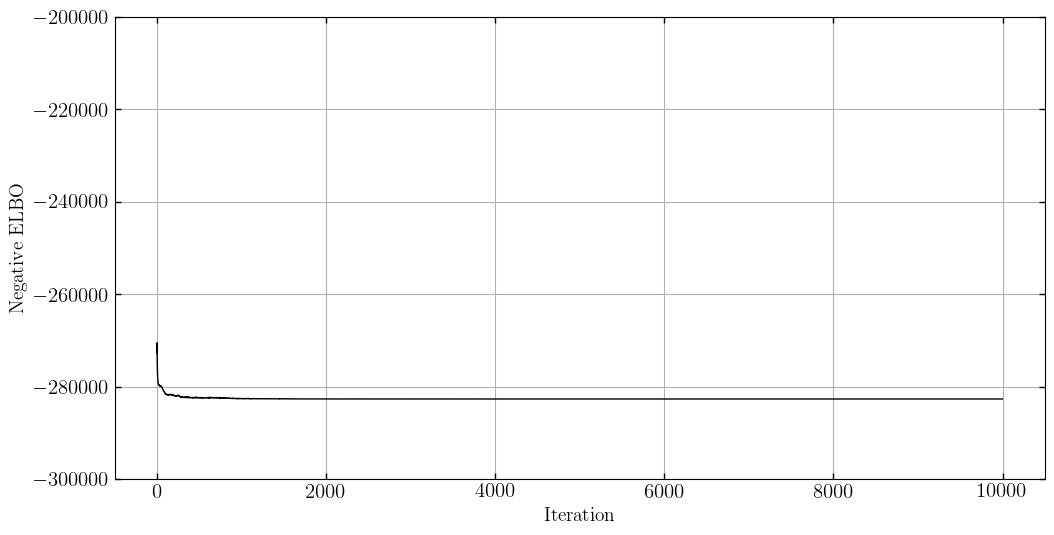

In [454]:
plt.figure(figsize=(12,6))
plt.plot(svi_results.losses, lw=1)
plt.ylim(-3e5, -2e5)
print(svi_results.losses[-1])
# plt.yscale('log')
plt.xlabel('Iteration') ; plt.ylabel('Negative ELBO')
plt.grid()
plt.show()

In [455]:
MAP_p_expanded = get_svi_params(mm, run_data, svi_results, full_guide, num_samples=1, key=jax.random.PRNGKey(42))

In [456]:
init_params['mixture-probs_auto_loc']

Array([0.984, 0.015, 0.001], dtype=float64)

In [457]:
svi_results.params['mixture-probs_auto_loc']

Array([0.98137472, 0.01571145, 0.00291383], dtype=float64)

In [458]:
print(MAP_p_expanded['mixture-probs'])

[0.98137472 0.01571145 0.00291383]


(-100.0, 20.0)

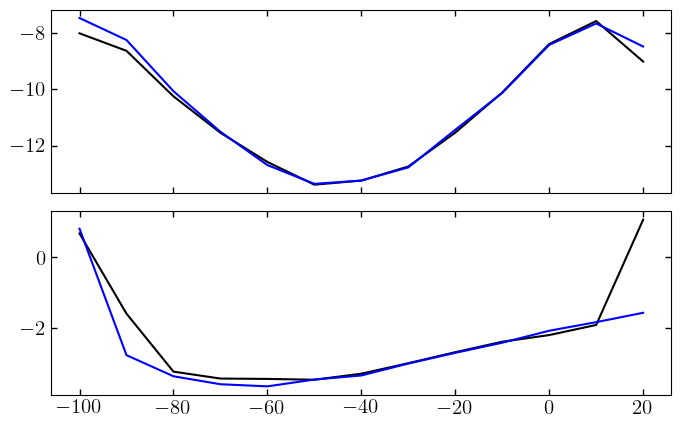

In [459]:
fig, [ax1, ax2] = plt.subplots(2,1,figsize=(8,5), sharex=True)
ax1.plot(mm['stream'].coord_parameters['pm1']['knots'], MAP_p_expanded['offtrack']['pm1']['loc_vals'])
ax1.plot(mm['stream'].coord_parameters['pm1']['knots'], MAP_p_expanded['stream']['pm1']['loc_vals'])
# ax1.plot(stream_model_mm.coord_parameters['pm1']['knots'], stream_params['pm1']['loc_vals'])

ax2.plot(mm['stream'].coord_parameters['pm2']['knots'], MAP_p_expanded['offtrack']['pm2']['loc_vals'])
ax2.plot(mm['stream'].coord_parameters['pm2']['knots'], MAP_p_expanded['stream']['pm2']['loc_vals'])
# ax2.plot(stream_model_mm.coord_parameters['pm2']['knots'], stream_params['pm2']['loc_vals'])
# ax3.plot(stream_model_mm.coord_parameters['rv']['knots'], stream_params['rv']['loc_vals'])
ax3.set_xlim(-100,20)

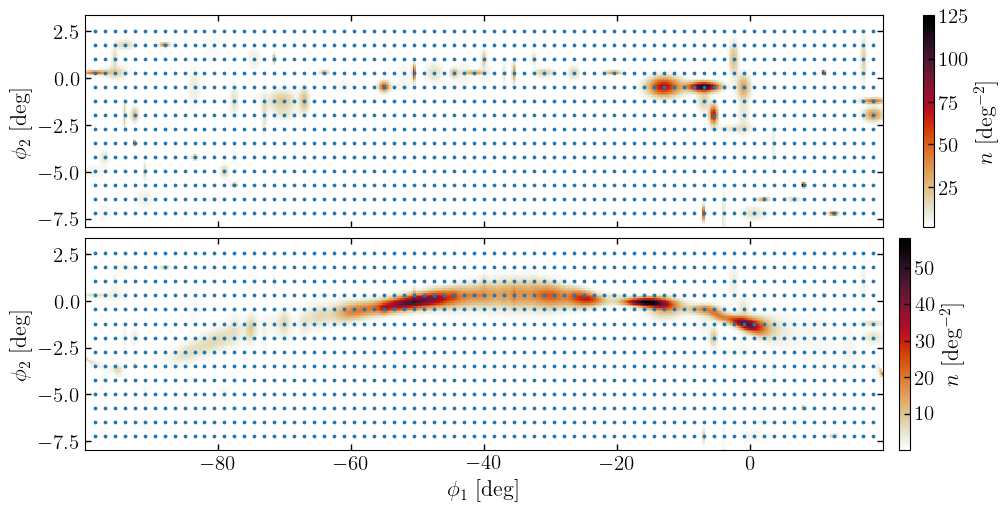

In [460]:
str_off_mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0])),
    components=[stream_model_mm, offtrack_model],
    # tied_coordinates={"offtrack": {"pm1": "stream", "pm2": "stream"}},
    )

str_off_mm_params = {
    "stream": MAP_p_expanded["stream"],
    "offtrack": MAP_p_expanded["offtrack"],
    "mixture-probs": MAP_p_expanded["mixture-probs"][1:]
}

bin_area = jnp.diff(plot_grids['phi1'])[0] * jnp.diff(plot_grids['phi2'])[0]

fig, [ax1, ax2] = plt.subplots(2,1,figsize=(10,5), sharex=True, constrained_layout=True)
_, _, pcms1 = mm['offtrack'].plot_model_projections(ndata=len(run_data_), 
                                                    grids=plot_grids, pars=MAP_p_expanded['offtrack'], grid_coord_names=[('phi1', 'phi2')], 
                                                    axes=ax1, pcolormesh_kwargs=dict(rasterized=True, cmap=cmap, vmin=1.25))
ax1.scatter(offtrack_phi12_locs[:, 0], offtrack_phi12_locs[:, 1], color="tab:blue", s=3)
cbar1 = fig.colorbar(pcms1[0], ax=ax1, )#ticks=jnp.array([0, 2, 4, 6, 8])*bin_area, pad=0.02,
           # format=mticker.FixedFormatter(['0', '2', '4', '6', '8']))

_, _, pcms2 = str_off_mm.plot_model_projections(ndata=len(run_data_),
                                                pars=str_off_mm_params, grids=plot_grids, grid_coord_names=[('phi1', 'phi2')], axes=ax2, label=True,
                                                pcolormesh_kwargs=dict(rasterized=True, cmap=cmap))
ax2.scatter(offtrack_phi12_locs[:, 0], offtrack_phi12_locs[:, 1], color="tab:blue", s=3)
cbar2 = fig.colorbar(pcms2[0], ax=ax2, ticks=jnp.array([0, 10, 20, 30, 40, 50, 60])*bin_area, pad=0.02,
           format=mticker.FixedFormatter(['0','10', '20', '30', '40', '50', '60']))




ax1.set_xlabel("")
cbar1.set_label(label=r'$n$ [deg$^{-2}$]', fontsize=16)
cbar2.set_label(label=r'$n$ [deg$^{-2}$]', fontsize=16)


# plt.savefig('../../paper_figures/offtrack_model.pdf')
# plt.savefig('../../paper_figures/offtrack_model.png')
plt.show()

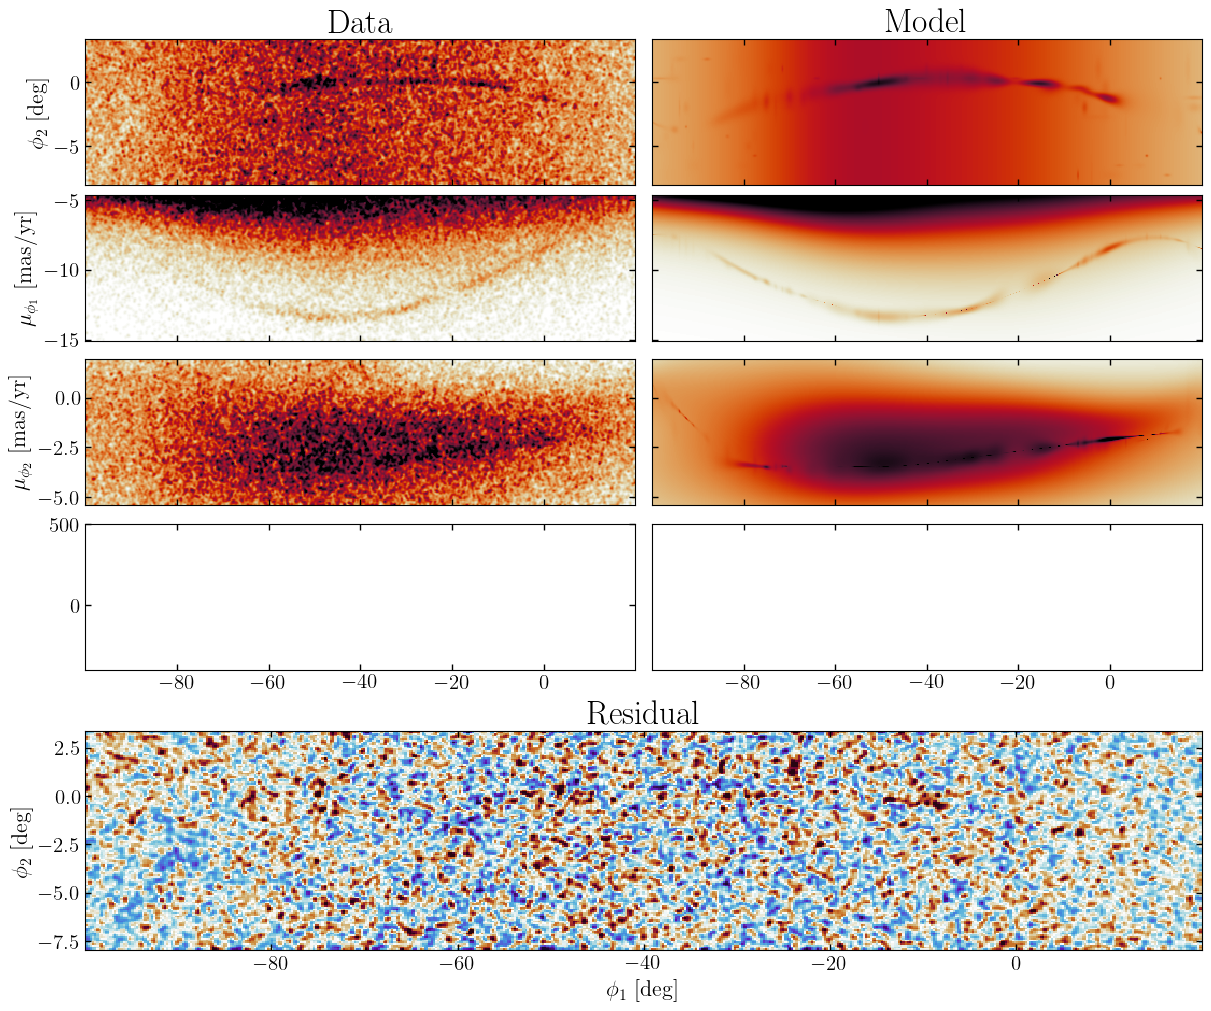

In [461]:
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 1.5], figure=fig, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax6 = fig.add_subplot(gs[2, 1], sharex=ax1, sharey=ax5)
ax7 = fig.add_subplot(gs[3, 0], sharex=ax1)
ax8 = fig.add_subplot(gs[3, 1], sharex=ax1, sharey=ax7)

ax9 = fig.add_subplot(gs[4, :], sharex=ax1)

plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=ax3,
    coord_names=[('phi1', 'pm1')],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
)
plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=[ax1, ax5],
    pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap),
    coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')]
)

mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, 
                          grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm1')],
                          pars=MAP_p_expanded, axes=[ax2,ax4], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap))
mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1', 'phi2'), ('phi1', 'pm2')],
                          pars=MAP_p_expanded, axes=[ax2,ax6], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))

mm.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_expanded,
    data=run_data, axes=ax9, label=True, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, rasterized=True, cmap=cmr.fusion),
    grid_coord_names=[('phi1', 'phi2')]
)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.label_outer()
ax8.yaxis.set_visible(False)
ax8.set_ylim(-400,500)

ax1.set_title('Data', fontsize=24)
ax2.set_title('Model', fontsize=24)
ax9.set_title('Residual', fontsize=24, pad=5)

# plt.savefig('../../paper_figures/full_model.pdf')
plt.show()

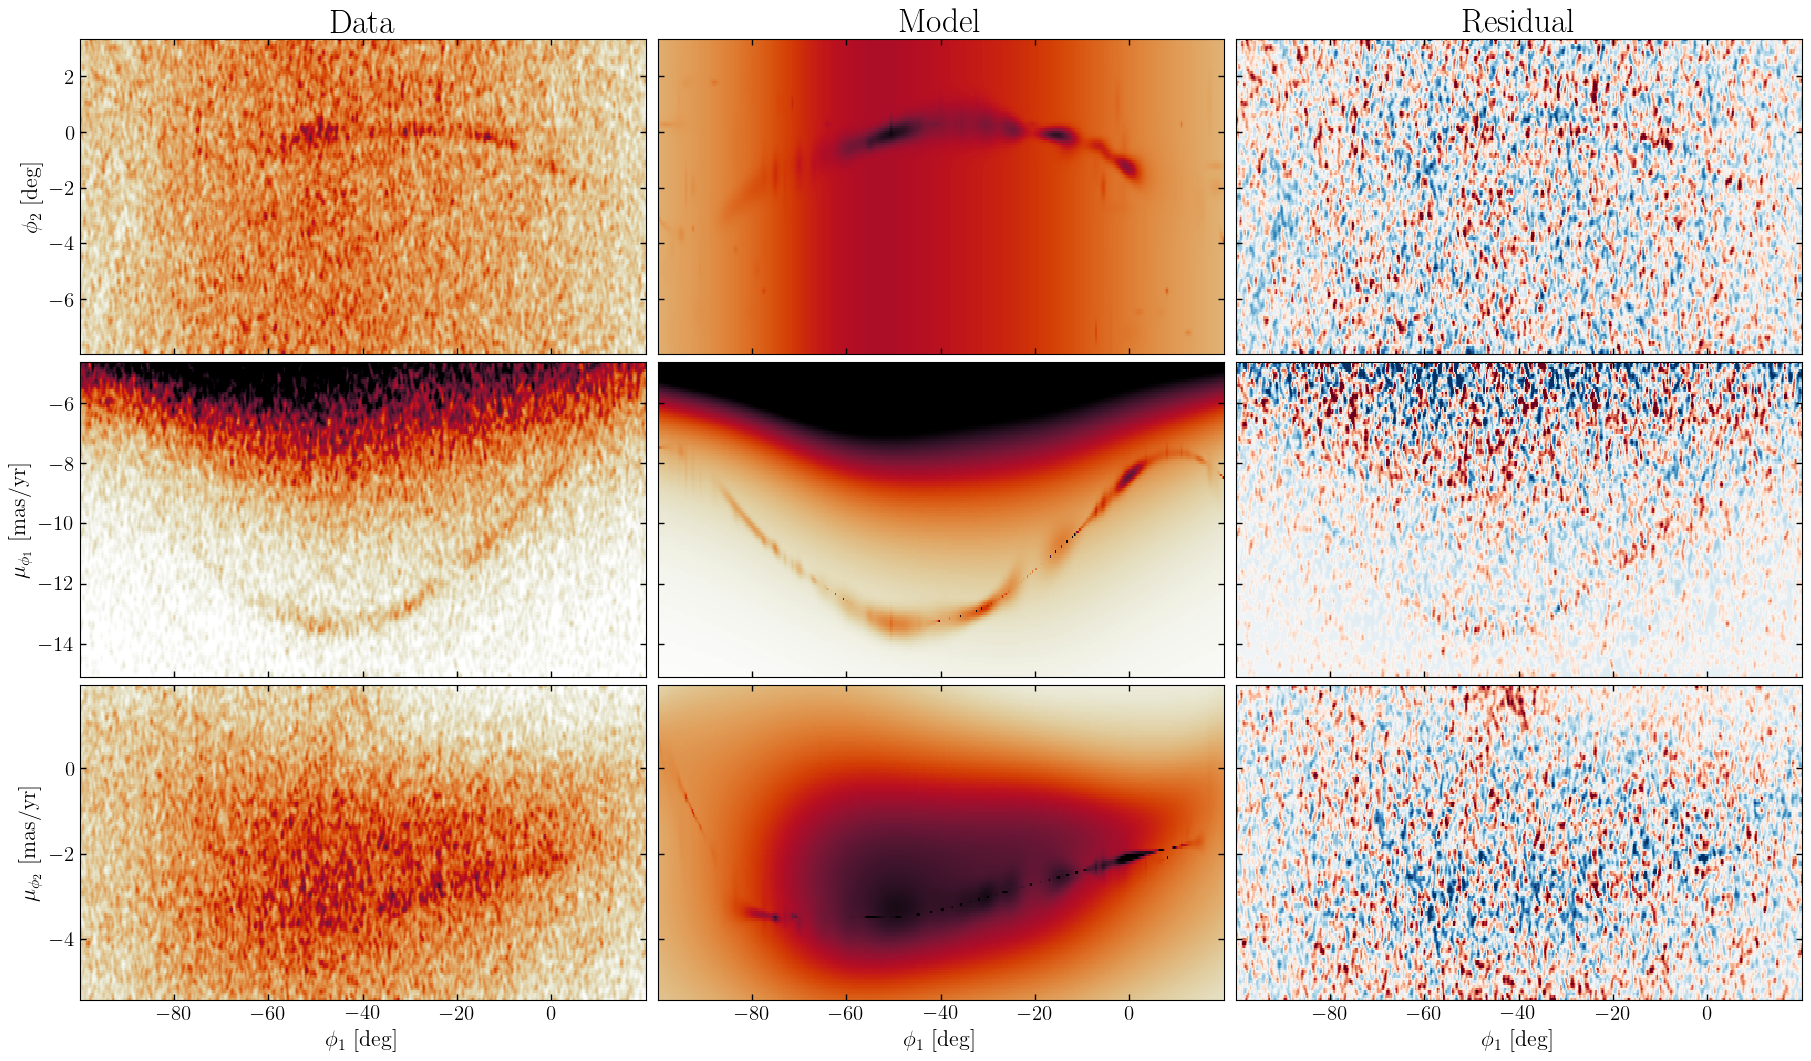

In [463]:
fig, axes = plt.subplots(
    len(mm.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(mm.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

#axes = jnp.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=axes[:, 0],
    coord_names=[('phi1','phi2'), ('phi1', 'pm1'), ('phi1', 'pm2')],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0, cmap=cmap)
    # coord_names=GD1BackgroundModel.coord_names,
)
# axes[3,0].hist2d(run_data_['phi1'][run_data_['rv'] != 0], run_data_['rv'][run_data_['rv'] != 0], bins=[128, 128], range=[[phi1_lim[0],phi1_lim[1]], [rv_lim[0],rv_lim[1]]], cmap=cmap)

mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, pars=MAP_p_expanded, grid_coord_names=[('phi1','phi2'), ('phi1', 'pm1'), ('phi1', 'pm2')],
                          axes=axes[:3, 1], label=False,
                          pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0, cmap=cmap))
# mm.plot_model_projections(ndata=len(run_data_), grids=plot_grids, grid_coord_names=[('phi1','rv')],
#                           pars=MAP_p_expanded, axes=axes[3, 1], label=False,
#                           pcolormesh_kwargs=dict(rasterized=True, vmax=20, vmin=0, cmap=cmap))
mm.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_expanded, grid_coord_names=[('phi1','phi2'), ('phi1', 'pm1'), ('phi1', 'pm2')],
    data=run_data, axes=axes[:3, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)

# plt.savefig('../figures/
plt.show()
